## Sift Evaluator

The objectives of this notebook are to:

- Define functions that query the data based on different parameters (distance metric, transformations?)
- Define functions to evaluate the truth of each returned query parameter
- Define functions to calculate mAP and precision@k for the above output
- Create a pipeline for evaluating the effects of different parameter set ups / transformations on mAP and p@k

______
# Evaluation Functions
____
### Imports

In [1]:
import numpy as np
import unittest
import sklearn.metrics.pairwise
import sklearn.preprocessing
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import time
import glob
import copy
import sklearn.decomposition

In [4]:
data = {}

NOTEBOOK_DIR = "/home/sean/Code/Pawsey/4. Clean"


data = {}

for data_subset in ["oldenburger", "sutton"]:
    subdir = "./data/" + data_subset
    data[data_subset] = {}

    for descriptor in os.listdir(subdir):

        if descriptor == "names":
            data[data_subset][descriptor] = {"ox" : {}, "par" : {}}
            for fname in os.listdir(subdir + "/" + descriptor):
                split_name = fname[:-4].split("-")
                dataset = split_name[0]
                if fname.endswith("y-names.npy"):
                    data[data_subset][descriptor][dataset]["y"] = np.load("./data/{}/{}/{}".format(data_subset, descriptor, fname))
                else:
                    difficulty = split_name[2]
                    data[data_subset][descriptor][dataset][difficulty] = np.load("./data/{}/{}/{}".format(data_subset, descriptor, fname))

        else:
            data[data_subset][descriptor] = {"ox" : {"E" : {}, "M" : {}, "H" :{}},
                                "par" : {"E" : {}, "M" : {}, "H" :{}}}
            for fname in os.listdir(subdir + "/" + descriptor):
                split_name = fname[:-4].split("-")
                if len(split_name) == 3:
                    pass
                else:
                    (_, xy, dataset, difficulty) = split_name
                    data[data_subset][descriptor][dataset][difficulty][xy] = np.load("./data/{}/{}/{}".format(data_subset, descriptor, fname))
        
        print("Loaded " + descriptor)

data["oldenburger"]["swin"]["ox"]["E"]["x"]

Loaded swin
Loaded vgg
Loaded resnet
Loaded names
Loaded vit
Loaded names
Loaded sift-10k
Loaded sift-1k


array([[ 0.4381919 , -1.1369115 , -0.49100572, ..., -0.27456677,
         0.38102797, -0.30554023],
       [-0.19804995,  0.02098738,  0.52111053, ...,  0.44540596,
         0.8620084 ,  0.18907186],
       [ 1.0216093 , -0.06300209, -0.06569103, ...,  0.02202551,
        -0.32440802,  0.3858102 ],
       ...,
       [ 0.74518114, -0.9655011 , -0.55623275, ..., -0.39560622,
         0.3983633 , -0.4672271 ],
       [ 0.4493655 , -0.97439206, -0.61376625, ..., -0.19914342,
         0.27447924, -0.3482531 ],
       [ 0.04259995,  0.09633142,  0.65417933, ...,  0.5438953 ,
         0.53027916,  0.03832415]], dtype=float32)

In [20]:
q = data["oldenburger"]["swin"]["ox"]["E"]["y"]
t = data["oldenburger"]["swin"]["ox"]["E"]["x"]
q_n = data["oldenburger"]["names"]["ox"]["y"]
t_n = data["oldenburger"]["names"]["ox"]["E"]

qe_query(q[0], t)

array([265, 462,  78, ..., 358, 477, 441])

____
### Query Functions

In [9]:
def basic_query(query, query_target, metric_function = sklearn.metrics.pairwise.euclidean_distances):
    """Return the indexes of the query_target images, arranged in ascending euclidean distance as compared to the query image"""
    
    query = query.reshape((1, -1))
    D = metric_function(query_target, query).squeeze()
    index = np.argsort(D)

    return(index)


In [14]:
b = np.array([[0,0],[1,1],[2,2]])
b[:2]

array([[0, 0],
       [1, 1]])

In [18]:
np.average(b, axis=0, weights = [1,1,2])

array([1.25, 1.25])

In [19]:
def qe_query(query, query_target, metric_function=sklearn.metrics.pairwise.euclidean_distances, type="qe baseline", n=5, alpha=1):
    """Run a query with query expansion, supported methods:
       - "qe baseline" : described in Total Recall (2007), new result is based on alpha proportion of requerying (e.g. alpha = 1,
                         then results after the top 5 will be completely determined by the top five"""
    
    original_results = basic_query(query, query_target, metric_function)

    if type == "qe baseline":
        # find top n results, combine top n into a new query, append results of new query to top n
        top_n = query_target[:n]
        second_query = np.average(top_n, axis=0)
        
        if alpha != 1:
            combined_queries = np.vstack([query, second_query])
            second_query = np.vstack([query, second_query], axis = 0, weights = [1-alpha, alpha])

        new_results = basic_query(second_query, query_target, metric_function)
        pruned_new_results = new_results[np.logical_not(np.isin(new_results, top_n))]
        results = np.concatenate([original_results, pruned_new_results])

        return(results)

    print("Something went wrong")
    


# def new_expanded_query(original_query_results, query_target_features, type = "n", n = 5):
#     """Return an expanded query to based on the top n results of the initial query results."""
    
#     top_n_features = query_target_features.loc[:n]

#     if type == "n":
#         return(pd.DataFrame([top_n_features.apply(np.mean)]).values)

#     else:
#         if type == "alpha":
#             raise ValueError("Alpha query expansion not implemented")
#         elif type == "linear1":
#             weights = [(n-i)/n for i in range(n)]
#         elif type == "linear2":
#             weights = [(n-i)/n + 1 for i in range(n)]
#         elif type == "fractional":
#             weights = [1/i for i in range(1, n+1)]
        
#         return(pd.DataFrame([top_n_features.apply(np.average, weights = weights)]))


# def qe_query(query, query_target, metric_function = sklearn.metrics.pairwise.euclidean_distances, type = "n", n=5):
#     """Perform a query, then run query expansion and return the new results."""

#     original_results = basic_query(query, query_target, metric_function)
#     new_query = new_expanded_query(original_results, query_target, type, n)
#     new_results = basic_query(new_query, query_target, metric_function)
#     return(new_results)

_____
### Query to Truth Value Functions

In [4]:
def query_results_to_truth_values(query_image_building, query_results, image_names):
    """Convert the index results of a query to an array of booleans corresponding to whether the correct image was retrieved."""
    return([query_image_building == image_names[index] for index in query_results])

_______
### Truth Value Metrics Functions

In [5]:
## Potential Improvements
# 1. Precision_at_k to print precision at last true value?
# 2. Create a more computationally efficient (/combined?) version.
# 3. Add recall_at_k

def precision_at_k(truth_values, k, warnings=True):
    """Return proportions of true values in the first k elements.
    If warnings=True and all true values occur before the kth element, raise an error"""
    p_at_k = truth_values[:k].count(True) / k

    # if warnings:
    #     if k < len(truth_values):
    #         if truth_values[k:].count(True) == 0:
    #             raise ValueError("All true values are before the first k values")
    
    return(p_at_k)


def average_precision(truth_values):
    """Given a boolean input of whether returned query values are correct or false, return the average precision.
    e.g. average_precision([True, True, False, True]) ~ 0.85
    """
    precisions = []
    for (index, val) in enumerate(truth_values):
        if val: # == True
            precisions.append(truth_values[:index + 1].count(True) / (index + 1))      

    return(np.mean(precisions))

____
### Total Metrics


In [6]:
def compute_metrics(train_features, test_features, train_names, test_names, query_function, metric_function, average_mean_precision = True, k_values = [5,10,20], **kwargs):
    """Run each test feature against the train features,"""
    average_precisions = []
    precisions_at_k = {}
    for k in k_values:
        precisions_at_k[k] = []
    
    for (test_feature, test_feature_name) in zip(test_features.iterrows(), test_names):
        query_image_features = test_feature[1].values # extract the values for the iterrows row object
        query_results = query_function(query_image_features, train_features, metric_function, **kwargs)
        truth_values = query_results_to_truth_values(test_feature_name, query_results, train_names)
        
        average_precisions.append(average_precision(truth_values))
        for k in precisions_at_k:
            p_at_k = precision_at_k(truth_values, k, warnings=False)
            precisions_at_k[k].append(p_at_k)
    
    for (k_value, list_of_precisions) in precisions_at_k.items():
        precisions_at_k[k_value] = np.mean(list_of_precisions)
    
    return(np.mean(average_precisions), precisions_at_k)


## Outdated version

# def mean_average_precision(train_features, test_features, train_names, test_names, distance_metric):
#     """descriptive docstring do map yeah"""
#     average_precisions = []
    
#     for (test_feature, test_feature_name) in zip(test_features.iterrows(), test_names):
#         features_as_array = test_feature[1].values # extract the values for the iterrows row object
#         query_results = basic_query(features_as_array, train_features, distance_metric)
#         truth_values = query_results_to_truth_values(test_feature_name, query_results, train_names)
#         average_precisions.append(average_precision(truth_values))
    
#     return(np.mean(average_precisions))

___________
### Tests

In [7]:
class TestQuery(unittest.TestCase):

    def test_basicquery(self):
        test_query = np.array([0,0,0,0])
        test_query_target = pd.DataFrame(data={"a" : [4,0,0,0],
                             "b" : [0,1,2,0],
                             "c" : [0,0,0,0],
                             "d" : [0,0,0,6]})
        self.assertTrue(np.allclose(basic_query(test_query, test_query_target), [1,2,0,3]))

class TestTruthValues(unittest.TestCase):

    def test_queryresultstotruthvalues(self):
        test_query_image_building = "A"
        test_query_results = [0,4,3,2,1,5,6]
        test_image_names = ["A", "B", "C", "D", "A", "A", "D"]
        results = query_results_to_truth_values(test_query_image_building, test_query_results, test_image_names)
        self.assertTrue(np.array_equal(results, [True, True, False, False, False, True, False]))

class TestMetrics(unittest.TestCase):

    def test_precision_at_k(self):
        self.assertEqual(precision_at_k([True,False,True, True],4), 0.75)
        self.assertEqual(precision_at_k([True, False, True, False, True], 2), 0.5)

    def test_averageprecision(self):
        self.assertAlmostEqual(average_precision([True, False, True, True]), np.mean([1,2/3,3/4]))
        self.assertAlmostEqual(average_precision([False, False, True, False, True]), np.mean([1/3,2/5]))
    
    # def test_meanaverageprecision(self)


unittest.main(argv=[''], verbosity=2, exit=False)

test_averageprecision (__main__.TestMetrics) ... ok
test_precision_at_k (__main__.TestMetrics) ... ok
test_basicquery (__main__.TestQuery) ... ok
test_queryresultstotruthvalues (__main__.TestTruthValues) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.004s

OK


_______
# Data Loading

_____________
## New Sift Features

In [3]:
basedir = "/home/sean/Code/Pawsey/3. Data/New_SIFT"

sift_raw = {"roxford5k" : {}, "rparis6k" : {}}

os.chdir(basedir + "/SIFT")
for file_name in os.listdir():
    split_name = file_name.split("-")
    dataset, num_features, difficulty, _ = split_name

    num_features = int(num_features)
    if num_features not in sift_raw[dataset].keys():
        sift_raw[dataset][num_features] = {}
    
    sift_raw[dataset][num_features][difficulty] = pd.read_csv(file_name)
    print("Loaded " + file_name)

sift_raw["roxford5k"][1000]["easy"].head()


Loaded rparis6k-10000-hard-SIFT.csv
Loaded roxford5k-10000-medium-SIFT.csv
Loaded rparis6k-1000-querym-SIFT.csv
Loaded rparis6k-1000-querye-SIFT.csv
Loaded roxford5k-1000-medium-SIFT.csv
Loaded roxford5k-1000-queryh-SIFT.csv
Loaded roxford5k-1000-easy-SIFT.csv
Loaded rparis6k-10000-queryh-SIFT.csv
Loaded roxford5k-10000-easy-SIFT.csv
Loaded rparis6k-1000-hard-SIFT.csv
Loaded roxford5k-10000-querye-SIFT.csv
Loaded roxford5k-1000-hard-SIFT.csv
Loaded roxford5k-10000-querym-SIFT.csv
Loaded rparis6k-10000-medium-SIFT.csv
Loaded rparis6k-1000-queryh-SIFT.csv
Loaded roxford5k-1000-querye-SIFT.csv
Loaded rparis6k-10000-querye-SIFT.csv
Loaded roxford5k-10000-hard-SIFT.csv
Loaded roxford5k-1000-querym-SIFT.csv
Loaded roxford5k-10000-queryh-SIFT.csv
Loaded rparis6k-1000-easy-SIFT.csv
Loaded rparis6k-10000-easy-SIFT.csv
Loaded rparis6k-10000-querym-SIFT.csv
Loaded rparis6k-1000-medium-SIFT.csv


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.000000,0.008328,0.000000,0.213189,0.041077,0.000000,0.011529,0.016828,0.016603,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.016982,0.0,0.000000,0.011505
1,0.0,0.026717,0.024817,0.038176,0.018326,0.085688,0.042927,0.000000,0.000000,0.012369,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.025303,0.0,0.019041,0.008571
2,0.0,0.002802,0.036436,0.016014,0.046126,0.005135,0.033442,0.010809,0.010518,0.005189,...,0.007394,0.0,0.000000,0.0,0.0,0.0,0.018575,0.0,0.007988,0.003596
3,0.0,0.017057,0.015844,0.032496,0.054600,0.039075,0.023491,0.021934,0.000000,0.000000,...,0.022507,0.0,0.000000,0.0,0.0,0.0,0.016154,0.0,0.000000,0.021888
4,0.0,0.015522,0.050464,0.025876,0.088728,0.046228,0.103324,0.009980,0.000000,0.000000,...,0.000000,0.0,0.011005,0.0,0.0,0.0,0.022051,0.0,0.000000,0.000000


In [4]:
names = {"roxford5k" : {}, "rparis6k" : {}}

os.chdir(basedir + "/names")
for data_file in os.listdir():
    split_name = data_file[:-4].split("-")
    dataset, _, difficulty, _ = split_name
    names[dataset][difficulty] = np.load(data_file)

names["rparis6k"]["easy"]

array(['invalides', 'moulinrouge', 'louvre', ..., 'eiffel', 'triomphe',
       'eiffel'], dtype='<U11')

In [21]:
## Save SIFT data to clean directory

# base_dir = "/home/sean/Code/Pawsey/4. Clean/data/sutton"
# os.chdir(base_dir)

# for dataset in sift_raw:
#     for num_features in sift_raw[dataset]:
#         for (difficulty, features) in sift_raw[dataset][num_features].items():
#             num_features2 = str(num_features)[:-3]
#             dataset2 = {"roxford5k" : "ox", "rparis6k" : "par"}[dataset]
#             xy2 = "y" if str.startswith(difficulty, "q") else "x"
#             difficulty2 = str.upper(difficulty[-1] if xy2 == "y" else difficulty[0])
#             fname = "sift{}k-{}-{}-{}.npy".format(num_features2, xy2, dataset2, difficulty2)
#             np.save("sift-{}k/{}".format(num_features2, fname), features.to_numpy())

In [25]:
# for dataset in names:
#     dataset2 = {"roxford5k" : "ox", "rparis6k" : "par"}[dataset]
#     for diff in ["easy", "medium", "hard"]:
#         diff2 = diff[0].upper()
#         fname = "{}-x-{}-names.npy".format(dataset2, diff2)
#         np.save("names/" + fname, names[dataset][diff])
#     np.save("names/{}-y-names.npy".format(dataset2), names[dataset]['querye'])
        

____
### Apply Normalisation and PCA

In [11]:
full_data = {"raw" : sift_raw,
             "vector normalised" : copy.deepcopy(sift_raw),
             "feature normalised" : copy.deepcopy(sift_raw),
             "pca_128" : copy.deepcopy(sift_raw),
             "pca_256" : copy.deepcopy(sift_raw),
             "pca_64" : copy.deepcopy(sift_raw),
             "pca_512" : copy.deepcopy(sift_raw)}

for dataset_name in sift_raw:
    for num_features in sift_raw[dataset_name]:
        for difficulty in ["easy", "medium", "hard"]:
            try:
                train = copy.deepcopy(sift_raw[dataset_name][num_features][difficulty])
                test = copy.deepcopy(sift_raw[dataset_name][num_features]["query" + difficulty[0]])

                normaliser = sklearn.preprocessing.Normalizer()
                full_data["vector normalised"][dataset_name][num_features][difficulty] = pd.DataFrame(normaliser.transform(train))
                full_data["vector normalised"][dataset_name][num_features]["query" + difficulty[0]] = pd.DataFrame(normaliser.transform(test))

                full_data["feature normalised"][dataset_name][num_features][difficulty] = pd.DataFrame(normaliser.transform(train.transpose())).transpose()
                full_data["feature normalised"][dataset_name][num_features]["query" + difficulty[0]] = pd.DataFrame(normaliser.transform(test.transpose())).transpose()

                pca_64 = sklearn.decomposition.PCA(n_components=64)
                pca_64.fit(train)
                full_data["pca_64"][dataset_name][num_features][difficulty] = pd.DataFrame(pca_64.transform(train))
                full_data["pca_64"][dataset_name][num_features]["query" + difficulty[0]] = pd.DataFrame(pca_64.transform(test))

                pca_128 = sklearn.decomposition.PCA(n_components=128)
                pca_128.fit(train)
                full_data["pca_128"][dataset_name][num_features][difficulty] = pd.DataFrame(pca_128.transform(train))
                full_data["pca_128"][dataset_name][num_features]["query" + difficulty[0]] = pd.DataFrame(pca_128.transform(test))

                pca_256 = sklearn.decomposition.PCA(n_components=256)
                pca_256.fit(train)
                full_data["pca_256"][dataset_name][num_features][difficulty] = pd.DataFrame(pca_256.transform(train))
                full_data["pca_256"][dataset_name][num_features]["query" + difficulty[0]] = pd.DataFrame(pca_256.transform(test))

                pca_512 = sklearn.decomposition.PCA(n_components=512)
                pca_512.fit(train)
                full_data["pca_512"][dataset_name][num_features][difficulty] = pd.DataFrame(pca_512.transform(train))
                full_data["pca_512"][dataset_name][num_features]["query" + difficulty[0]] = pd.DataFrame(pca_512.transform(test))

            except KeyError:
                print("No data for {} {} {}".format(dataset_name, num_features, difficulty))
            


No data for rparis6k 10000 easy
No data for rparis6k 10000 hard


_____
### Sample Query

In [34]:
diff = "easy"
n_features = 10000
dataset = "roxford5k"
transformation = "raw"

compute_metrics(train_features = full_data[transformation][dataset][n_features][diff],
                test_features = full_data[transformation][dataset][n_features]["querye"],
                train_names = names[dataset][diff],
                test_names = names[dataset]['querye'],
                query_function=qe_query,
                metric_function = sklearn.metrics.pairwise.euclidean_distances,
                alpha=0.5)

(0.23876766739353442,
 {5: 0.42, 10: 0.38285714285714284, 20: 0.33285714285714285})

____
## Analysis
____
### Basic SIFT

In [ ]:
dataset_names = []
features = []
difficulties = []
m_aps = []

for dataset_name in full_data["raw"]:
    for n_features in full_data["raw"][dataset_name]:
        for difficulty in ["easy", "medium", "hard"]:
            try:
                m_ap = 

            except KeyError:
                pass


____
### Test all experimental setups

In [41]:
# Compute results for all experimental setups


# set parameters
test_distance_metrics = {"euclidean" : sklearn.metrics.pairwise.euclidean_distances,
           "cosine" : sklearn.metrics.pairwise.cosine_distances}
query_functions = {"basic" : basic_query, "nqe" : qe_query, "nqe alpha = 0.5" : ""}
k_vals = [5, 10]


# solve
results = {"dataset" : [], "distance_metric" : [],'difficulty':[], 'num_features' : [], 'mean_ap' : [], 'transformation' : [], "query type" : []}
for k in k_vals:
    results["precision at {}".format(k)] = []

for (query_type, query_function) in [["basic", basic_query]]:
    for (metric_name, metric_function) in test_distance_metrics.items():
        for transformation_name in full_data:
            for dataset_name in full_data[transformation_name]:
                for num_features in full_data[transformation_name][dataset_name]:
                    for difficulty in ["easy", "medium", "hard"]:
                        try:
                            print("Running {} query on {} {} {} features {}".format(query_type, transformation_name, dataset_name, num_features, difficulty))
                            
                            train = full_data[transformation_name][dataset_name][num_features][difficulty]
                            test = full_data[transformation_name][dataset_name][num_features]["query" + difficulty[0]]

                            if query_type == "nqe alpha = 0.5":
                                (mean_ap, p_at_k) = compute_metrics(train_features = train,
                                                        test_features = test,
                                                        train_names = names[dataset_name][difficulty],
                                                        test_names = names[dataset_name]["query" + difficulty[0]],
                                                        query_function=qe_query,
                                                        metric_function = metric_function,
                                                        k_values=k_vals,
                                                        alpha = 0.5)
                            else:
                                (mean_ap, p_at_k) = compute_metrics(train_features = train,
                                                        test_features = test,
                                                        train_names = names[dataset_name][difficulty],
                                                        test_names = names[dataset_name]["query" + difficulty[0]],
                                                        query_function=query_function,
                                                        metric_function = metric_function,
                                                        k_values=k_vals)                          
                
                    
                            results['distance_metric'].append(metric_name)
                            results["dataset"].append(dataset_name)
                            results['transformation'].append(transformation_name)
                            results['num_features'].append(num_features)
                            results['mean_ap'].append(mean_ap)
                            results['difficulty'].append(difficulty)
                            results['query type'].append(query_type)
                            for (k, p_at_k) in p_at_k.items():
                                results["precision at {}".format(k)].append(p_at_k)
                        
                        except KeyError:
                            print("NO DATA")


basic_results_df = pd.DataFrame(results)
basic_results_df["dataset n_feat"] = basic_results_df["dataset"] + basic_results_df["num_features"].map(lambda x: " features:10k" if x == 10000 else " features:1k")
basic_results_df


Running basic query on raw roxford5k 10000 features easy
Running basic query on raw roxford5k 10000 features medium
Running basic query on raw roxford5k 10000 features hard
Running basic query on raw roxford5k 1000 features easy
Running basic query on raw roxford5k 1000 features medium
Running basic query on raw roxford5k 1000 features hard
Running basic query on raw rparis6k 1000 features easy
Running basic query on raw rparis6k 1000 features medium
Running basic query on raw rparis6k 1000 features hard
Running basic query on raw rparis6k 10000 features easy
NO DATA
Running basic query on raw rparis6k 10000 features medium
Running basic query on raw rparis6k 10000 features hard
NO DATA
Running basic query on vector normalised roxford5k 10000 features easy
Running basic query on vector normalised roxford5k 10000 features medium
Running basic query on vector normalised roxford5k 10000 features hard
Running basic query on vector normalised roxford5k 1000 features easy
Running basic query

,dataset,distance_metric,difficulty,num_features,mean_ap,transformation,query type,precision at 5,precision at 10,dataset n_feat
0,roxford5k,euclidean,easy,10000,0.358068,raw,basic,0.420000,0.382857,roxford5k features:10k
1,roxford5k,euclidean,medium,10000,0.332913,raw,basic,0.442857,0.405714,roxford5k features:10k
2,roxford5k,euclidean,hard,10000,0.330696,raw,basic,0.382857,0.341429,roxford5k features:10k
3,roxford5k,euclidean,easy,1000,0.288325,raw,basic,0.311429,0.275714,roxford5k features:1k
4,roxford5k,euclidean,medium,1000,0.321600,raw,basic,0.420000,0.382857,roxford5k features:1k
...,...,...,...,...,...,...,...,...,...,...
135,roxford5k,cosine,hard,1000,0.269820,pca_512,basic,0.337143,0.311429,roxford5k features:1k
136,rparis6k,cosine,easy,1000,0.469191,pca_512,basic,0.794286,0.762857,rparis6k features:1k
137,rparis6k,cosine,medium,1000,0.445570,pca_512,basic,0.862857,0.828571,rparis6k features:1k
138,rparis6k,cosine,hard,1000,0.360347,pca_512,basic,0.625714,0.595714,rparis6k features:1k


<AxesSubplot:xlabel='dataset n_feat', ylabel='mean_ap'>

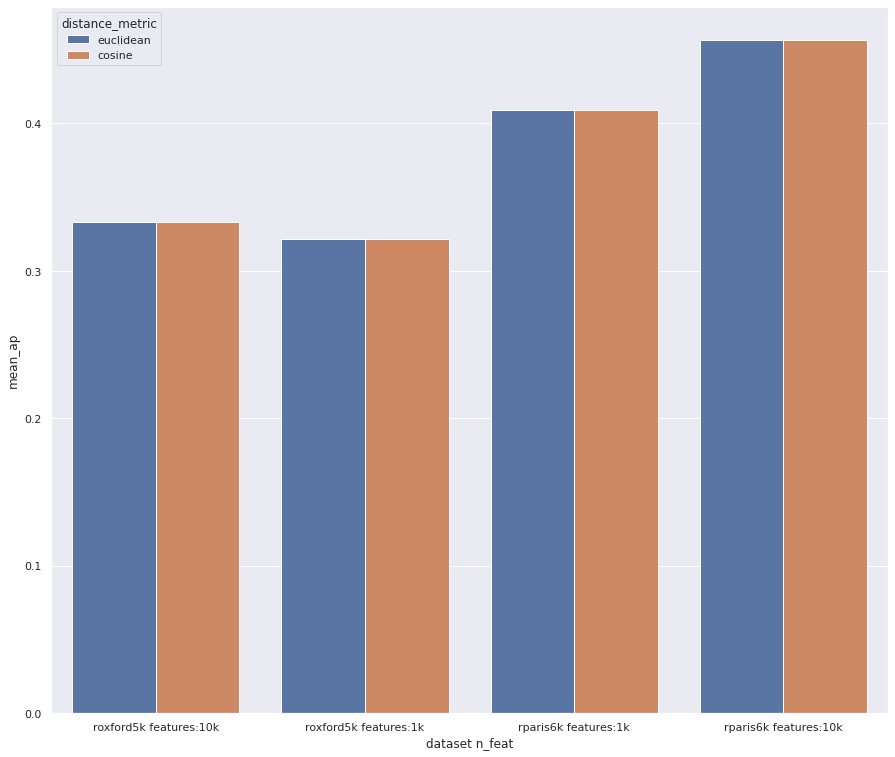

In [86]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(15,13)})

view_raw_euclid = basic_results_df[(basic_results_df["transformation"] == "raw") & (basic_results_df["difficulty"] == "medium")]

sns.barplot(data=view_raw_euclid, x="dataset n_feat", y="mean_ap", hue="distance_metric")

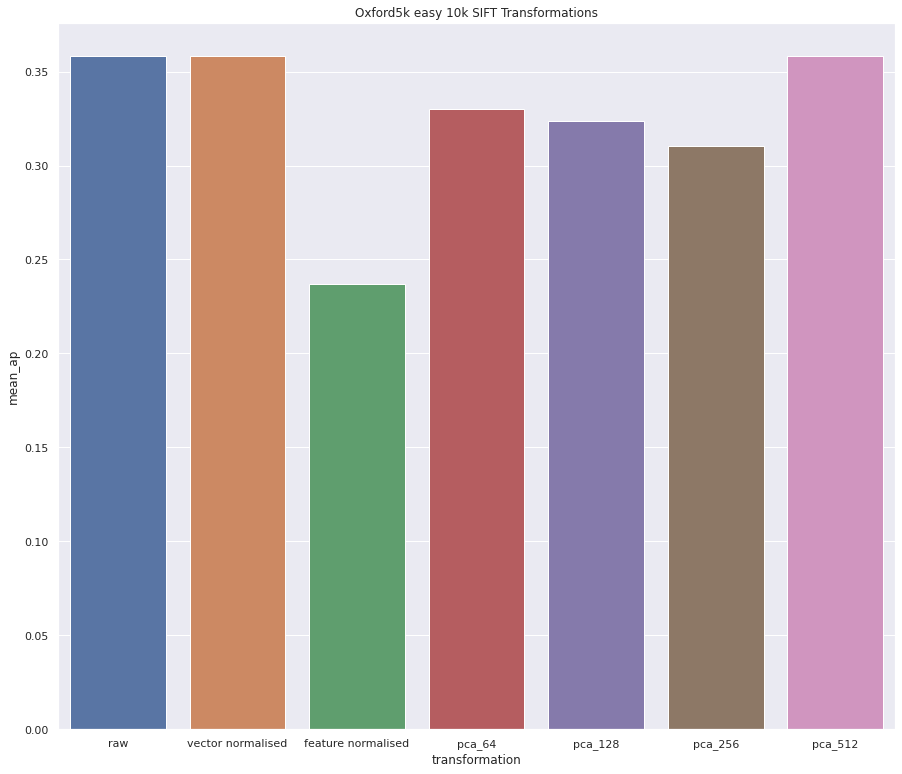

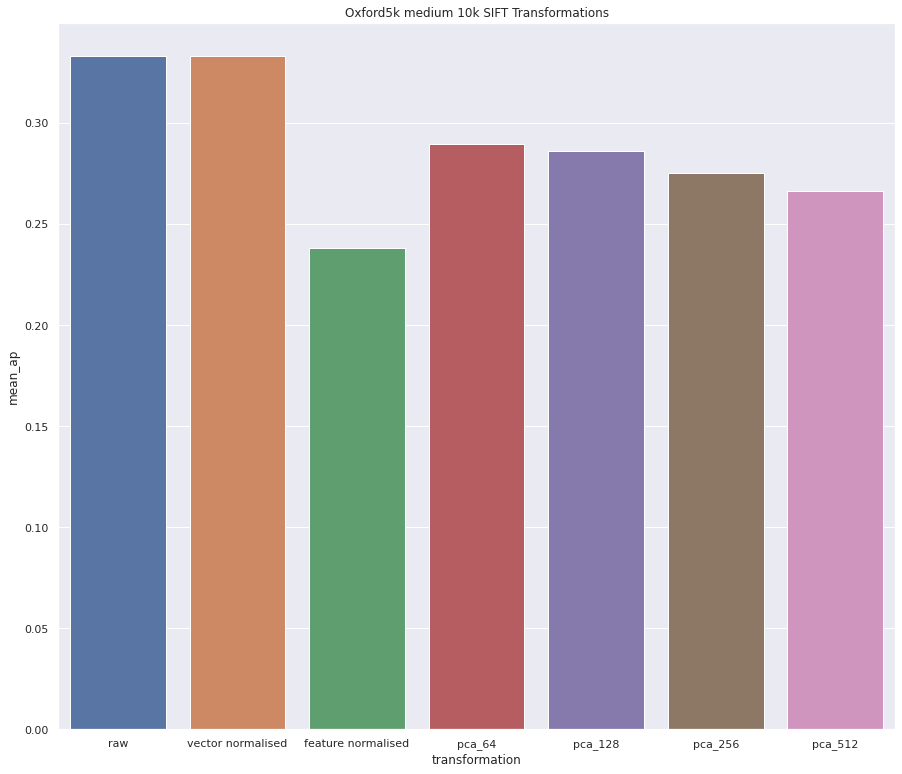

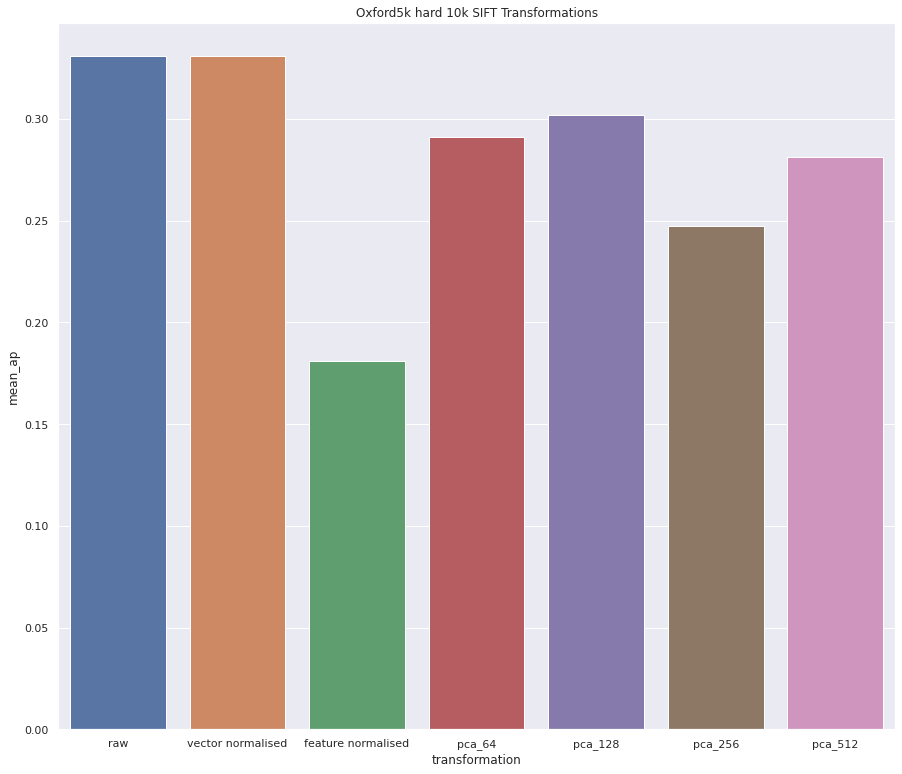

In [60]:
ax = {}
for difficulty in ["easy", "medium", "hard"]:
    view_ox10k = basic_results_df[(basic_results_df["dataset"] == "roxford5k")  & (basic_results_df["num_features"] == 10000) &
                                (basic_results_df["distance_metric"] == "euclidean") & (basic_results_df["difficulty"] == difficulty)]

    ax[difficulty] = sns.barplot(data=view_ox10k, x="transformation", y="mean_ap", order = ["raw", "vector normalised", "feature normalised", "pca_64", "pca_128", "pca_256", "pca_512"])
    ax[difficulty].set_title("Oxford5k {} 10k SIFT Transformations".format(difficulty))
    plt.show(ax[difficulty])

_____
## Investigating the Effect of AQE

In [69]:
dataset_name = "roxford5k"
difficulty = "easy"
num_features = 10000
transformation_name = "raw"
mean_aps, alphas = [], []

for alpha in [0.5, 1]:
    train = full_data[transformation_name][dataset_name][num_features][difficulty]
    test = full_data[transformation_name][dataset_name][num_features]["query" + difficulty[0]]
    (mean_ap, p_at_k) = compute_metrics(train_features = train,
                        test_features = test,
                        train_names = names[dataset_name][difficulty],
                        test_names = names[dataset_name]["query" + difficulty[0]],
                        query_function= qe_query,
                        metric_function = sklearn.metrics.pairwise.euclidean_distances,
                        k_values=[],
                        n=5,
                        alpha=alpha)
    mean_aps.append(mean_ap)
    alphas.append(alpha)
    

In [70]:
mean_aps


[0.23876766739353442, 0.23856910585283458]

In [72]:
# set parameters
test_distance_metrics = {"euclidean" : sklearn.metrics.pairwise.euclidean_distances,
           "cosine" : sklearn.metrics.pairwise.cosine_distances}
query_functions = {"basic" : basic_query, "nqe" : qe_query}
k_vals = [5, 10]


# solve
results = {"dataset" : [], "distance_metric" : [],'difficulty':[], 'num_features' : [], 'mean_ap' : [], 'transformation' : [], "query type" : []}
for k in k_vals:
    results["precision at {}".format(k)] = []

for (query_type, query_function) in query_functions.items():
    for (metric_name, metric_function) in test_distance_metrics.items():
        for transformation_name in ["raw", "vector normalised", "pca_64", "pca_512"]:
            for dataset_name in ["roxford5k"]:
                for num_features in full_data[transformation_name][dataset_name]:
                    for difficulty in ["easy", "medium", "hard"]:
                        try:
                            print("Running {} query on {} {} {} features {}".format(query_type, transformation_name, dataset_name, num_features, difficulty))
                            
                            train = full_data[transformation_name][dataset_name][num_features][difficulty]
                            test = full_data[transformation_name][dataset_name][num_features]["query" + difficulty[0]]

                            (mean_ap, p_at_k) = compute_metrics(train_features = train,
                                                                test_features = test,
                                                                train_names = names[dataset_name][difficulty],
                                                                test_names = names[dataset_name]["query" + difficulty[0]],
                                                                query_function=query_function,
                                                                metric_function = metric_function,
                                                                k_values=k_vals)                          
                        
                    
                            results['distance_metric'].append(metric_name)
                            results["dataset"].append(dataset_name)
                            results['transformation'].append(transformation_name)
                            results['num_features'].append(num_features)
                            results['mean_ap'].append(mean_ap)
                            results['difficulty'].append(difficulty)
                            results['query type'].append(query_type)
                            for (k, p_at_k) in p_at_k.items():
                                results["precision at {}".format(k)].append(p_at_k)
                        
                        except KeyError:
                            print("NO DATA")


qe_results_df = pd.DataFrame(results)
qe_results_df["dataset n_feat"] = qe_results_df["dataset"] + qe_results_df["num_features"].map(lambda x: " features:10k" if x == 10000 else " features:1k")
qe_results_df

Running basic query on raw roxford5k 10000 features easy
Running basic query on raw roxford5k 10000 features medium
Running basic query on raw roxford5k 10000 features hard
Running basic query on raw roxford5k 1000 features easy
Running basic query on raw roxford5k 1000 features medium
Running basic query on raw roxford5k 1000 features hard
Running basic query on vector normalised roxford5k 10000 features easy
Running basic query on vector normalised roxford5k 10000 features medium
Running basic query on vector normalised roxford5k 10000 features hard
Running basic query on vector normalised roxford5k 1000 features easy
Running basic query on vector normalised roxford5k 1000 features medium
Running basic query on vector normalised roxford5k 1000 features hard
Running basic query on pca_64 roxford5k 10000 features easy
Running basic query on pca_64 roxford5k 10000 features medium
Running basic query on pca_64 roxford5k 10000 features hard
Running basic query on pca_64 roxford5k 1000 fea

,dataset,distance_metric,difficulty,num_features,mean_ap,transformation,query type,precision at 5,precision at 10,dataset n_feat
0,roxford5k,euclidean,easy,10000,0.358068,raw,basic,0.420000,0.382857,roxford5k features:10k
1,roxford5k,euclidean,medium,10000,0.332913,raw,basic,0.442857,0.405714,roxford5k features:10k
2,roxford5k,euclidean,hard,10000,0.330696,raw,basic,0.382857,0.341429,roxford5k features:10k
3,roxford5k,euclidean,easy,1000,0.288325,raw,basic,0.311429,0.275714,roxford5k features:1k
4,roxford5k,euclidean,medium,1000,0.321600,raw,basic,0.420000,0.382857,roxford5k features:1k
...,...,...,...,...,...,...,...,...,...,...
91,roxford5k,cosine,medium,10000,0.248117,pca_512,nqe,0.494286,0.457143,roxford5k features:10k
92,roxford5k,cosine,hard,10000,0.246059,pca_512,nqe,0.437143,0.377143,roxford5k features:10k
93,roxford5k,cosine,easy,1000,0.224727,pca_512,nqe,0.388571,0.330000,roxford5k features:1k
94,roxford5k,cosine,medium,1000,0.238863,pca_512,nqe,0.471429,0.407143,roxford5k features:1k


In [82]:
qe_results_df["dataset n_feat"] = qe_results_df["dataset"] + qe_results_df["num_features"].map(lambda x: " features:10k" if x == 10000 else " features:1k")

view_qe = qe_results_df[(qe_results_df["transformation"] == "raw") &
                                (qe_results_df["distance_metric"] == "euclidean") & (qe_results_df["num_features"] == 10000)]

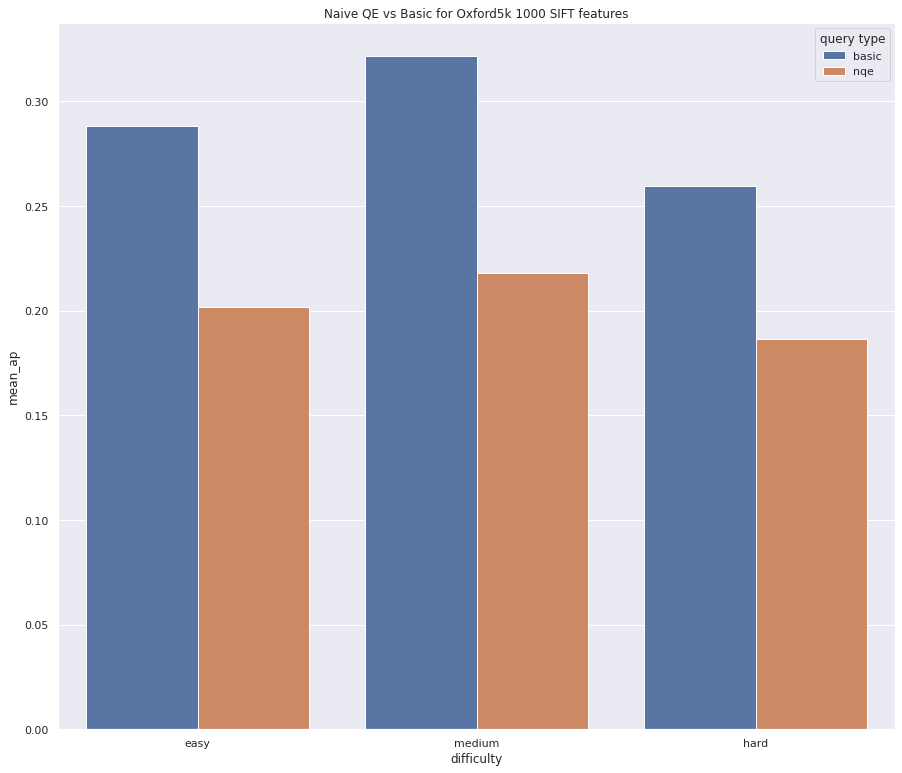

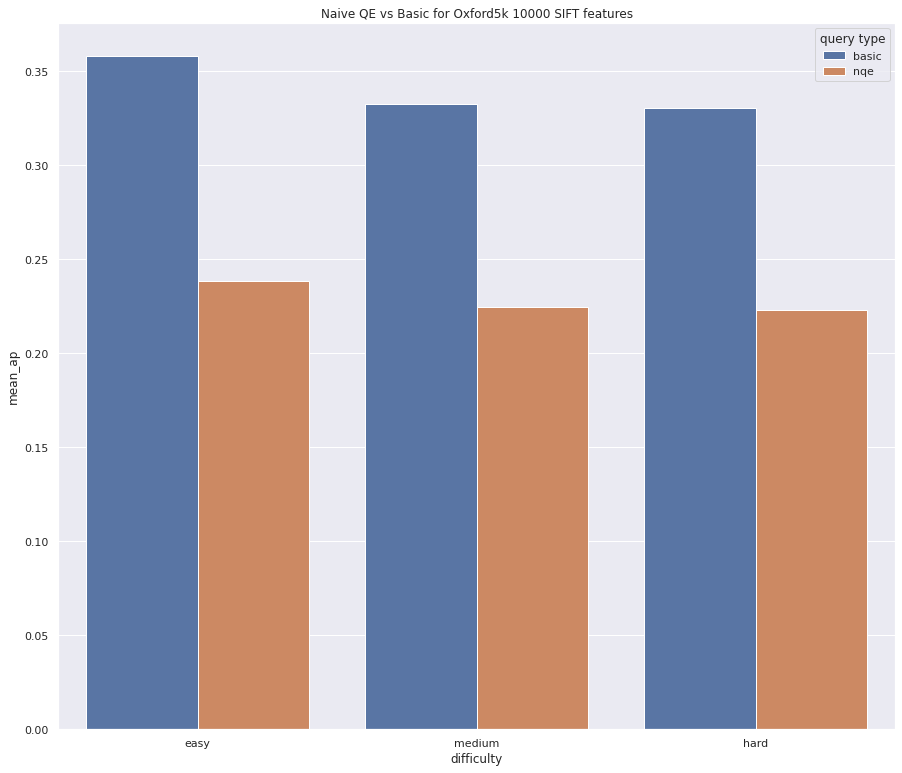

In [84]:
ax2 = {}
for n_features in [1000, 10000]:
    view_qe = qe_results_df[(qe_results_df["transformation"] == "raw") &
                                (qe_results_df["distance_metric"] == "euclidean") & (qe_results_df["num_features"] == n_features)]

    ax2[difficulty] = sns.barplot(data=view_qe, x="difficulty", y="mean_ap", hue="query type")
    ax2[difficulty].set_title("Naive QE vs Basic for Oxford5k {} SIFT features".format(n_features))
    plt.show(ax2[difficulty])

____
## Testing RANSAC Spatial Verification

____
### Visualising results

In [63]:
pd.options.display.max_rows = 84
results_df.sort_values(by="mean_aps", ascending=False).head(10)

,distance_metrics,transformations,bovw_sizes,mean_aps,precision at 5,precision at 10,precision at 20
39,cosine,feature norm,100000,0.699703,0.301818,0.238182,0.184545
25,cosine,raw features,100000,0.668247,0.301818,0.238182,0.184545
74,nan_euclidean,vector norm,100000,0.668247,0.301818,0.238182,0.184545
32,cosine,vector norm,100000,0.668247,0.301818,0.238182,0.184545
67,nan_euclidean,raw features,100000,0.668247,0.301818,0.238182,0.184545
11,euclidean,vector norm,100000,0.668247,0.301818,0.238182,0.184545
4,euclidean,raw features,100000,0.668247,0.301818,0.238182,0.184545
41,cosine,feature norm,50000,0.648848,0.301818,0.238182,0.184545
6,euclidean,raw features,50000,0.619884,0.301818,0.238182,0.184545
27,cosine,raw features,50000,0.619884,0.301818,0.238182,0.184545


Odd:
cosine feature norm bovw files for 100000 Words : 0.6997034939349722
euclidean feature norm bovw files for 100000 Words : 0.20411431859694523

/home/sean/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/sean/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


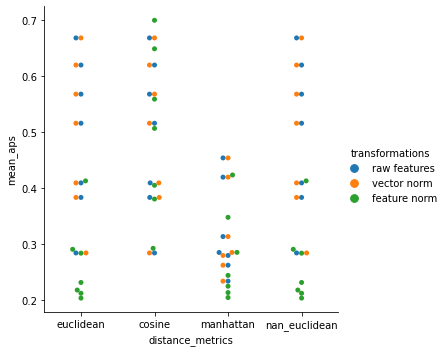

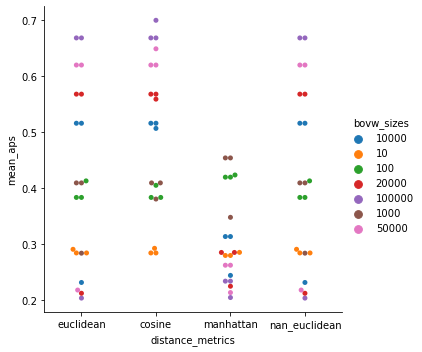

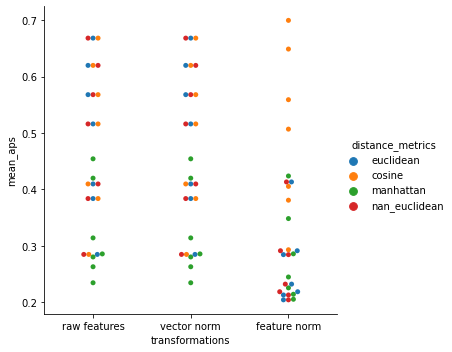

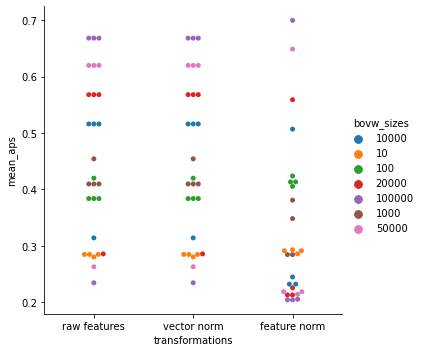

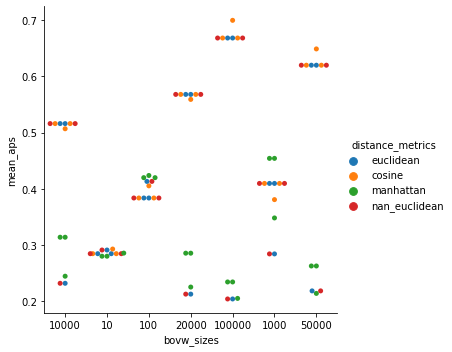

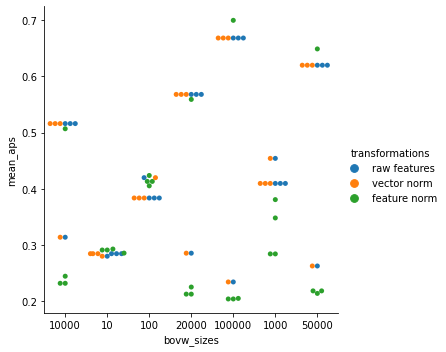

In [65]:
for column1 in results_df.columns[:3]:
    for column2 in results_df.columns[:3]:
        if column1 != column2:
            sns.catplot(x=column1, y="mean_aps", data=results_df, kind="swarm", hue=column2)

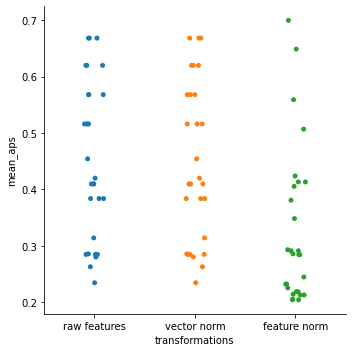

In [56]:
sns.catplot(x="transformations", y="mean_aps", data=results_df)